In [1]:
import os

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers


In [2]:
# Seed to reproduce results
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
train_df = pd.read_json('stock_train.json')
test_df = pd.read_json('stock_test.json')

In [4]:
train_df

,text,label,label_id
0,"Tại thị trường trong nước, khảo sát lúc 9 giờ ...",positive,0
1,tăng 50.000 đồng/lượng ở cả hai chiều mua và b...,positive,0
2,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
3,Vàng lại bật tăng vượt ngưỡng 2.000 USD/ounce,positive,0
4,tăng 24 USD/ounce so với cùng giờ sáng qua,positive,0
...,...,...,...
1511,Danh mục đầu tư 60/40 là mô hình phân chia tài...,neutral,2
1512,"Theo tính toán của Vanguard, lợi nhuận hàng nă...",neutral,2
1513,Nhóm chuyên gia JP Morgan xem xét 200 loại tài...,neutral,2
1514,Kết luận đưa ra là các nguyên tắc cốt lõi của ...,neutral,2


In [5]:
test_df


,text,label,label_id
0,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
1,"Như vậy, trong 2 ngày qua, giá vàng nhẫn đã tă...",positive,0
2,"Giá vàng thế giới bật tăng trở lại, khi lực cầ...",positive,0
3,"Tại thị trường thế giới, thời điểm lúc 9 giờ 3...",positive,0
4,"Tuy nhiên, sau đó lực cầu bắt đáy mạnh đã giúp...",positive,0
...,...,...,...
997,"Ngoài 47 triệu cổ phiếu khớp lệnh, HAG còn ghi...",neutral,2
998,báo cáo giải trình của SHS cho biết,neutral,2
999,"Cuối quý I, SHS nắm giữ 2.240 tỷ đồng cổ phiếu...",neutral,2
1000,SHS còn nắm giữ hơn 420 tỷ đồng TCB với giá tr...,neutral,2


In [6]:
# Label One-Hot-Encoding
label_encoded = sklearn.preprocessing.OneHotEncoder(sparse=False).fit_transform(pd.DataFrame([*list(train_df.label_id), *list(test_df.label_id)]))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.text, label_encoded[:len(train_df)]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.text, label_encoded[len(train_df):]))

# Batches
BUFFER_SIZE = 10000
BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
    print(len(example))
    print('Texts: ', example.numpy()[:1])
    print('Labels: ', label.numpy()[:1])

128
Texts:  [b'V\xe1\xbb\x9bi vi\xe1\xbb\x87c \xc4\x91\xc6\xb0a s\xe1\xbb\x9f h\xe1\xbb\xafu v\xe1\xbb\x81 d\xc6\xb0\xe1\xbb\x9bi ng\xc6\xb0\xe1\xbb\xa1ng 5%, SMBC kh\xc3\xb4ng c\xe1\xba\xa7n c\xc3\xb4ng b\xe1\xbb\x91 th\xc3\xb4ng tin nh\xe1\xbb\xafng l\xe1\xba\xa7n giao d\xe1\xbb\x8bch sau \xc4\x91\xc3\xb3']
Labels:  [[0. 0. 1.]]


In [8]:
# Encoder Vocab Size
VOCAB_SIZE = 10000

# Encoder
encoder = layers.TextVectorization(VOCAB_SIZE)

# Adapt TextVectorization for Train text to sets the layer's vocabulary
encoder.adapt(train_dataset.map(lambda text, label: text))

# Vocab
print(f"Vocab_size: {len(encoder.get_vocabulary())}")
encoder.get_vocabulary()[:10]

Vocab_size: 2279


['', '[UNK]', 'và', 'trong', 'tăng', 'với', 'cổ', 'của', 'có', 'đầu']

In [9]:
# Model
model = Sequential([
    encoder,
    layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True
        ),
    layers.Bidirectional(layers.GRU(64, return_sequences = True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.GRU(32)),
    layers.Dropout(0.3),
    layers.Dense(32, activation = "relu"),
    layers.Dense(3, activation = "softmax")])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         291712    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         74496     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                        

In [10]:
# Compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(5 * 1e-3),
    metrics = 'acc'
)

# Train
history_training = model.fit(
    train_dataset,
    epochs = 50,
    validation_data = test_dataset
)

Epoch 1/50
12/12 [==============================] - 30s 921ms/step - loss: 0.6464 - acc: 0.3747 - val_loss: 0.6062 - val_acc: 0.4920
Epoch 2/50
12/12 [==============================] - 5s 411ms/step - loss: 0.4692 - acc: 0.6715 - val_loss: 0.5214 - val_acc: 0.6118
Epoch 3/50
12/12 [==============================] - 6s 526ms/step - loss: 0.2675 - acc: 0.8496 - val_loss: 0.5626 - val_acc: 0.6467
Epoch 4/50
12/12 [==============================] - 6s 513ms/step - loss: 0.1397 - acc: 0.9208 - val_loss: 0.7359 - val_acc: 0.6427
Epoch 5/50
12/12 [==============================] - 5s 406ms/step - loss: 0.0905 - acc: 0.9525 - val_loss: 0.7082 - val_acc: 0.6477
Epoch 6/50
12/12 [==============================] - 7s 578ms/step - loss: 0.0593 - acc: 0.9716 - val_loss: 0.8092 - val_acc: 0.6487
Epoch 7/50
12/12 [==============================] - 5s 414ms/step - loss: 0.0424 - acc: 0.9815 - val_loss: 0.9732 - val_acc: 0.6297
Epoch 8/50
12/12 [==============================] - 6s 532ms/step - loss: 0

(0.0, 1.0)

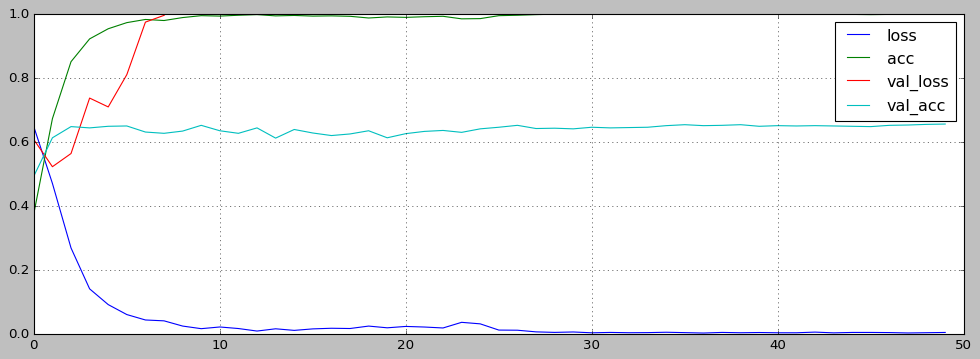

In [11]:
# Visualization
pd.DataFrame(history_training.history).plot(figsize = (15,5))
plt.grid(True)
plt.gca().set_ylim(0,1)


32/32 [==============================] - 7s 24ms/step
              precision    recall  f1-score   support

    positive       0.70      0.68      0.69       358
    negative       0.72      0.67      0.70       323
     neutral       0.56      0.61      0.58       321

    accuracy                           0.65      1002
   macro avg       0.66      0.65      0.65      1002
weighted avg       0.66      0.65      0.66      1002



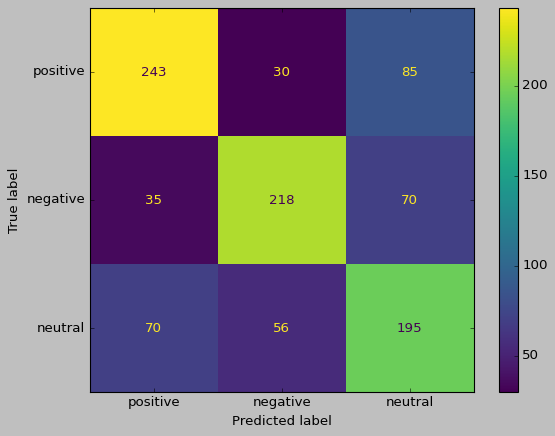

In [12]:
target_names = ['positive',
 'negative',
 'neutral']
# Evaluation
train_loss, train_acc = model.evaluate(train_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

# Prediction
preds = model.predict(test_df.text)
preds = tf.math.argmax(preds, -1)

# Report
report = classification_report(test_df.label_id, preds, target_names=target_names, digits=2)
print(report)
cm = confusion_matrix(test_df.label_id, preds)
_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
_display.plot()
plt.show()

In [13]:
model.save("bigru", save_format='tf')
